In [1]:
# ! pip install -r requirements.txt

In [2]:
# ! pip install tensorflow=2.7

In [3]:
# ! conda install -c conda-forge cudatoolkit=10.1 cudnn=7.6

In [4]:
! python -c "import tensorflow as tf; print(tf.test.is_built_with_cuda())"

True


2023-09-29 15:13:06.131258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll


In [5]:
! python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-29 15:13:09.075273: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2023-09-29 15:13:10.867128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2023-09-29 15:13:11.911386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 with Max-Q Design computeCapability: 7.5
coreClock: 1.125GHz coreCount: 36 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 327.88GiB/s
2023-09-29 15:13:11.911413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2023-09-29 15:13:11.914719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_10.dll
2023-09-29 15:13:11.917985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic 

In [6]:
# importing required libraries

import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import pandas as pd

# import os
# import random
# from scikit-image import io
# from shutil import copyfile
# import sys
# import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
images_boxable_train = 'labels/train/default-images-with-rotation.csv'
annotations_bbox_train = 'labels/train/default-annotations-bbox.csv'
class_descriptions_train = 'labels/train/class-descriptions.csv'

images_boxable_val = 'labels/val/default-images-with-rotation.csv'
annotations_bbox_val = 'labels/val/default-annotations-bbox.csv'
class_descriptions_val = 'labels/val/class-descriptions.csv'

dataset_dir = '../dataset/images'
train_dataset = dataset_dir + '/train'
val_dataset = dataset_dir + '/val'

## Dataset

### Training Dataset

In [8]:
# read the csv file using read_csv function of pandas
train = pd.read_csv(annotations_bbox_train)
train.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0003-RCC,NaN,benign_mass,1,0.874559,0.954789,0.434712,0.482127,0,-1,-1,-1,-1
1,0003-RMLO,NaN,benign_mass,1,0.905531,0.981633,0.759336,0.807656,0,-1,-1,-1,-1
2,0005-LMLO,NaN,benign_mass,1,0.181677,0.215643,0.397397,0.431267,0,-1,-1,-1,-1
3,0012-LCC,NaN,benign_mass,1,0.411526,0.464402,0.657751,0.704478,0,-1,-1,-1,-1
4,0012-LCC,NaN,benign_calcification,1,0.192100,0.287822,0.299241,0.379524,0,-1,-1,-1,-1


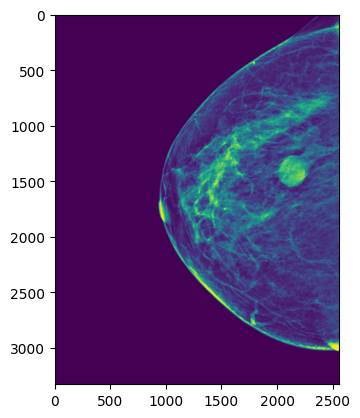

In [9]:
# reading single image using imread function of matplotlib
image = plt.imread(train_dataset + '/0022-RCC.png')
plt.imshow(image)

In [10]:
# Number of unique training images
train['ImageID'].nunique()

394

In [11]:
# Number of classes
train['LabelName'].value_counts()

malignant_mass             245
benign_calcification       174
benign_mass                155
malignant_calcification     79
Name: LabelName, dtype: int64

### Validation Dataset

In [12]:
# read the csv file using read_csv function of pandas
val = pd.read_csv(annotations_bbox_val)
val.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0014-RCC,NaN,benign_mass,1,0.708957,0.774883,0.129168,0.168837,0,-1,-1,-1,-1
1,0016-LMLO,NaN,malignant_mass,1,0.116028,0.340195,0.570989,0.672324,0,-1,-1,-1,-1
2,0016-RCC,NaN,benign_mass,1,0.946908,1.000000,0.331667,0.374004,0,-1,-1,-1,-1
3,0022-LCC,NaN,benign_calcification,1,0.441352,0.458473,0.698927,0.713606,0,-1,-1,-1,-1
4,0022-LCC,NaN,benign_calcification,1,0.320516,0.338617,0.807686,0.820856,0,-1,-1,-1,-1


In [13]:
val['ImageID'].nunique()

102

In [14]:
# Number of classes
val['LabelName'].value_counts()

malignant_mass             62
benign_calcification       47
benign_mass                42
malignant_calcification    17
Name: LabelName, dtype: int64

## Image Annotations

image width: 2560, image height: 3328 

xmin_pixel=2238, xmax_pixel=2444, ymin_pixel=1446, ymax_pixel=1604 



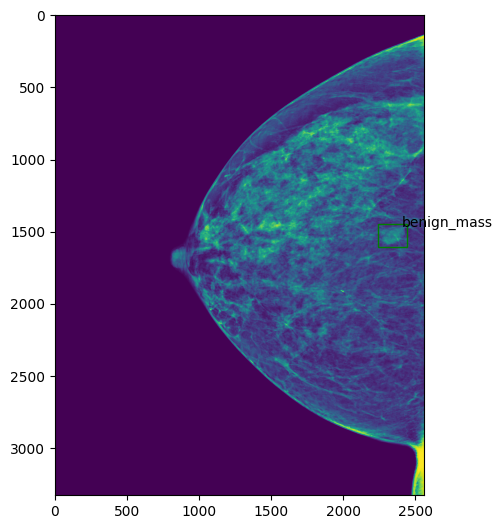

In [15]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(train_dataset + '/0003-RCC.png')
plt.imshow(image)

image_height, image_width = image.shape
print('image width: {}, image height: {} \n'.format(image_width, image_height))

# iterating over the image for different objects
for _,row in train[train.ImageID == "0003-RCC"].iterrows():
    
    xmin = int(row.XMin * image_width)
    xmax = int(row.XMax * image_width)
    ymin = int(row.YMin * image_height)
    ymax = int(row.YMax * image_height)
    
    # above also converts normalized coordinates to pixel values
    
    print("xmin_pixel={}, xmax_pixel={}, ymin_pixel={}, ymax_pixel={} \n".format(xmin, xmax, ymin, ymax))
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.LabelName == 'malignant_mass':
        edgecolor = 'r'
        ax.annotate('malignant_mass', xy=(xmax-40,ymin+20))
    elif row.LabelName == 'benign_calcification':
        edgecolor = 'b'
        ax.annotate('benign_calcification', xy=(xmax-40,ymin+20))
    elif row.LabelName == 'benign_mass':
        edgecolor = 'g'
        ax.annotate('benign_mass', xy=(xmax-40,ymin+20))
    elif row.LabelName == 'malignant_calcification':
        edgecolor = 'y'
        ax.annotate('malignant_calcification', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## Dataset format for Faster-RCNN code

### (fname_path, xmin, xmax, ymin, ymax, class_name)

In [16]:
train_df = []  # Create a list to store dictionaries

for _, row in train.iterrows():
    file_name = '{}/{}.png'.format(train_dataset, row.ImageID)
    image = plt.imread(file_name)
    img_width, img_height = image.shape
    
    # Create a dictionary for each row
    row_dict = {
        'FileName': file_name, 
        'XMin': int(row['XMin'] * img_width), 
        'XMax': int(row['XMax'] * img_width), 
        'YMin': int(row['YMin'] * img_height), 
        'YMax': int(row['YMax'] * img_height), 
        'LabelName': row['LabelName']
    }
    
    train_df.append(row_dict)

# Create the DataFrame from the list of dictionaries
train_df = pd.DataFrame(train_df)

In [17]:
train_df.head()

,FileName,XMin,XMax,YMin,YMax,LabelName
0,../dataset/images/train/0003-RCC.png,2910,3177,1112,1234,benign_mass
1,../dataset/images/train/0003-RMLO.png,3013,3266,1943,2067,benign_mass
2,../dataset/images/train/0005-LMLO.png,744,883,1322,1435,benign_mass
3,../dataset/images/train/0012-LCC.png,1685,1902,2188,2344,benign_mass
4,../dataset/images/train/0012-LCC.png,786,1178,995,1263,benign_calcification


In [18]:
val_df = []

for _,row in val.iterrows():
    filename = '{}/{}.png'.format(val_dataset, row.ImageID)
    image = plt.imread(filename)
    img_width, img_height = image.shape
    
    row_dict = {
        'FileName' : filename,
        'XMin': int(row['XMin'] * img_width), 
        'XMax': int(row['XMax'] * img_width), 
        'YMin': int(row['YMin'] * img_height), 
        'YMax': int(row['YMax'] * img_height), 
        'LabelName': row['LabelName']
    }

    val_df.append(row_dict)
    
val_df = pd.DataFrame(val_df)

In [19]:
val_df.head()

,FileName,XMin,XMax,YMin,YMax,LabelName
0,../dataset/images/val/0014-RCC.png,2359,2578,330,432,benign_mass
1,../dataset/images/val/0016-LMLO.png,475,1393,1900,2237,malignant_mass
2,../dataset/images/val/0016-RCC.png,3878,4096,1103,1244,benign_mass
3,../dataset/images/val/0022-LCC.png,1468,1525,1789,1826,benign_calcification
4,../dataset/images/val/0022-LCC.png,1066,1126,2067,2101,benign_calcification


In [20]:
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')

In [21]:
train_df.to_csv('annotations.txt', sep=',', index=False, header=False)
val_df.to_csv('annotation_val.txt', sep=',', index=False, header=False)